In [17]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Processing

In [2]:
train_data = datasets.MNIST(root='data', train=True, transform=ToTensor(), download = True)
test_data = datasets.MNIST(root = 'data', train=False, transform=ToTensor())
train_x, train_y = train_data.data, train_data.targets
train_x = train_x.reshape(train_x.shape[0],-1)
test_x, test_y = test_data.data, test_data.targets
test_x = test_x.reshape(test_x.shape[0],-1)
test_y_np = test_y.cpu().detach().numpy()


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Noramlize data

In [3]:
sc = StandardScaler()
train_x_norm = sc.fit_transform(train_x)
test_x_norm = sc.transform(test_x)

PCA

In [4]:
pca = PCA(n_components=10)
train_x_pca = pca.fit_transform(train_x_norm)
test_x_pca = pca.transform(test_x_norm)

LDA

In [5]:
lda = LinearDiscriminantAnalysis(n_components=8)
train_x_lda = lda.fit_transform(train_x_norm, train_y)
test_x_lda = lda.transform(test_x_norm)

# SVM

### PCA SVM

#### Linear SVM

In [6]:
svc_linear = svm.SVC(kernel = 'linear', C = 5).fit(train_x_pca, train_y)
predict_linear = svc_linear.predict(test_x_pca)
classification_linear = predict_linear - test_y_np
error_linear = np.round((np.count_nonzero(classification_linear == 0)/len(test_y_np))*100,2)
print('Test Accuracy for Linear Kernel : {} %'.format(error_linear))

Test Accuracy for Linear Kernel : 84.49 %


#### Polynomical SVM

In [9]:
svc_poly = svm.SVC(kernel = 'poly', degree = 5).fit(train_x_pca, train_y)
predict_poly = svc_poly.predict(test_x_pca)
classification_poly = predict_poly - test_y_np
error_poly = np.round((np.count_nonzero(classification_poly == 0)/len(test_y_np))*100,2)
print('Test Accuracy for Polynomial Kernel: {} %'.format(error_poly))

Test Accuracy for Polynomial Kernel: 88.37 %


#### RBF SVM

In [10]:
svc_RBF = svm.SVC(kernel = 'rbf', gamma = 0.1).fit(train_x_pca, train_y)
predict_RBF = svc_RBF.predict(test_x_pca)
classification_RBF = predict_RBF - test_y_np
error_RBF = np.round((np.count_nonzero(classification_RBF == 0)/len(test_y_np))*100,2)
print('Test Accuracy for RBF kernel: {} %'.format(error_RBF))

Test Accuracy for RBF kernel: 87.66 %


### LDA SVM

#### Linear SVM

In [25]:
svc_linear = svm.SVC(kernel = 'linear', C = 30).fit(train_x_lda, train_y)
predict_linear = svc_linear.predict(test_x_lda)
classification_linear = predict_linear - test_y_np
error_linear = np.round((np.count_nonzero(classification_linear == 0)/len(test_y_np))*100,2)
print('Test Accuracy for Linear Kernel : {} %'.format(error_linear))

Test Error for Linear Kernel : 10.86 %


#### Polynomical SVM

In [23]:
svc_poly = svm.SVC(kernel = 'poly', degree = 4).fit(train_x_lda, train_y)
predict_poly = svc_poly.predict(test_x_lda)
classification_poly = predict_poly - test_y_np
error_poly = np.round((np.count_nonzero(classification_poly == 0)/len(test_y_np))*100,2)
print('Test Accuracy for Polynomial Kernel: {} %'.format(error_poly))

Test Error for Polynomial Kernel: 13.36 %


#### RBF SVM

In [24]:
svc_RBF = svm.SVC(kernel = 'rbf', gamma = 0.1).fit(train_x_lda, train_y)
predict_RBF = svc_RBF.predict(test_x_lda)
classification_RBF = predict_RBF - test_y_np
error_RBF = np.round((np.count_nonzero(classification_RBF == 0)/len(test_y_np))*100,2)
print('Test Accuracy for RBF kernel: {} %'.format(error_RBF))

Test Error for RBF kernel: 8.24 %


# Logistic Regression

## Logistic Regression for PCA

#### Data preparation

In [36]:
n_class = 10
n_feature = train_x_pca.shape[1]
n_data = 60000
learning_rate = 10e-6
n_epoches = 200
weight = torch.zeros(n_feature+1, n_class).float()
train_y_matrix = torch.zeros(n_data, n_class).float()
for i in range(len(train_y)):
    train_y_matrix[i,train_y[i]] = 1
    
train_x_pca_app = torch.hstack((torch.from_numpy(train_x_pca),torch.ones(train_x_pca.shape[0],1)))
train_x_pca_transpose = torch.t(train_x_pca_app).float()

#### Training

In [37]:
train_loss = []

for epoch in tqdm(range(n_epoches)): 
    train_predict_y = torch.exp(torch.matmul(train_x_pca_app.float(),weight)).float()
    train_predict_y = train_predict_y/torch.sum(train_predict_y,dim=1,keepdim=True).float()
    pred_diff = train_predict_y - train_y_matrix
    loss = -torch.sum(train_y_matrix * torch.log(train_predict_y))
    train_loss.append(loss.item())
    weight = weight - learning_rate * train_x_pca_transpose@pred_diff

100%|██████████| 200/200 [00:02<00:00, 90.55it/s]


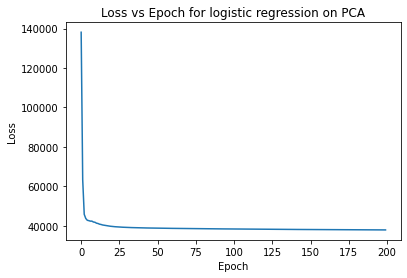

In [38]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for logistic regression on PCA')
plt.show()

#### Testing

In [39]:
test_x_pca_app = torch.hstack((torch.from_numpy(test_x_pca),torch.ones(test_x_pca.shape[0],1)))
test_predict_y = torch.exp(torch.matmul(test_x_pca_app.float(),weight)).float()
test_predict_y = test_predict_y.argmax(1)
test_predict_y_np = test_predict_y.cpu().detach().numpy()
classification_regre = test_predict_y_np - test_y_np
error = np.round((np.count_nonzero(classification_regre==0)/len(test_y_np))*100,2)
print('Test Accuracy for logistic regression on PCA : {} %'.format(error))

Test Accuracy for logistic regression on PCA : 80.34 %


### Logistic Regression for LDA

#### Data Processing

In [46]:
n_class = 10
n_feature = train_x_lda.shape[1]
n_data = 60000
learning_rate = 10e-6
n_epoches = 500
weight = torch.zeros(n_feature+1, n_class).float()
train_y_matrix = torch.zeros(n_data, n_class).float()
for i in range(len(train_y)):
    train_y_matrix[i,train_y[i]] = 1
    
train_x_lda_app = torch.hstack((torch.from_numpy(train_x_lda),torch.ones(train_x_lda.shape[0],1)))
train_x_lda_transpose = torch.t(train_x_lda_app).float()

#### Training

In [47]:
train_loss = []

for epoch in tqdm(range(n_epoches)): 
    train_predict_y = torch.exp(torch.matmul(train_x_lda_app.float(),weight)).float()
    train_predict_y = train_predict_y/torch.sum(train_predict_y,dim=1,keepdim=True).float()
    pred_diff = train_predict_y - train_y_matrix
    loss = -torch.sum(train_y_matrix * torch.log(train_predict_y))
    train_loss.append(loss.item())
    weight = weight - learning_rate * train_x_lda_transpose@pred_diff

100%|██████████| 500/500 [00:05<00:00, 99.32it/s] 


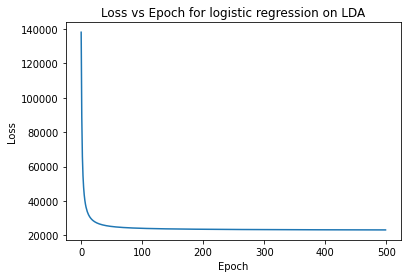

In [49]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for logistic regression on LDA')
plt.show()

#### Testing

In [50]:
test_x_lda_app = torch.hstack((torch.from_numpy(test_x_lda),torch.ones(test_x_lda.shape[0],1)))
test_predict_y = torch.exp(torch.matmul(test_x_lda_app.float(),weight)).float()
test_predict_y = test_predict_y.argmax(1)
test_predict_y_np = test_predict_y.cpu().detach().numpy()
classification_regre = test_predict_y_np - test_y_np
error = np.round((np.count_nonzero(classification_regre==0)/len(test_y_np))*100,2)
print('Test Accuracy for logistic regression on LDA : {} %'.format(error))

Test Accuracy for logistic regression on LDA : 88.33 %
